In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8750818794248067979
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6142318141437361598
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11740552911960830790
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 10132288730663060064
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


In [5]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

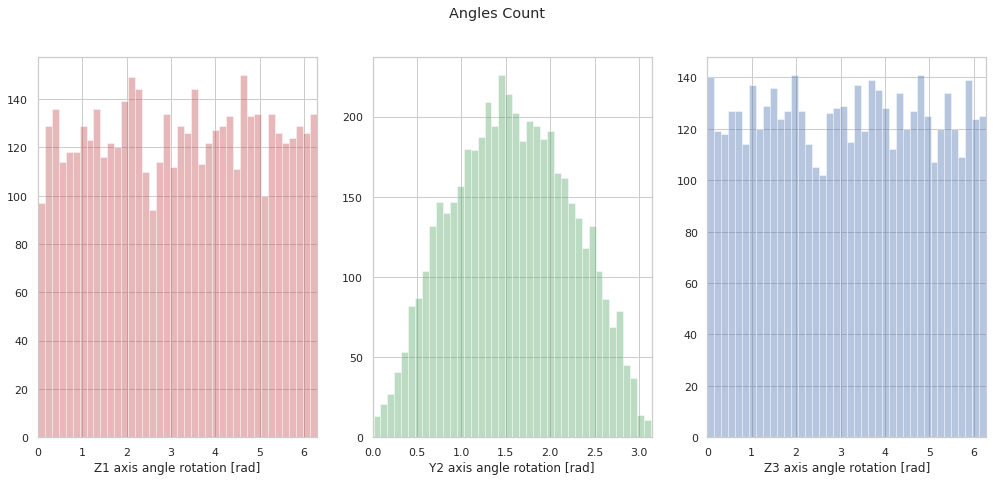

In [9]:
plot_angles_count(angles_true)

---

## Angle Recovery: Perfect Distance < 2

In [10]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [11]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [12]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

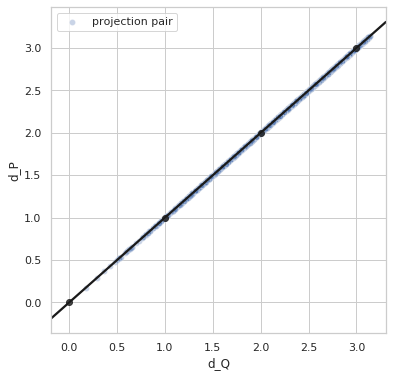

<Figure size 432x288 with 0 Axes>

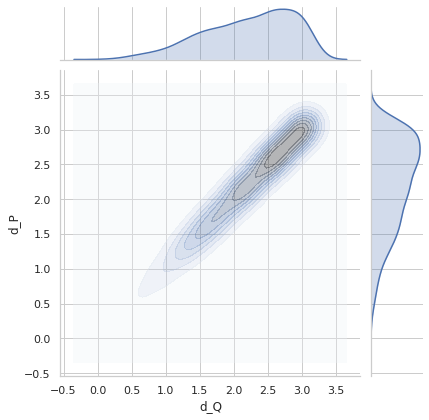

Variance = 0.0
Min. angle recovery loss possible = 0.0


In [13]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [11]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles


def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01, 
                         optimization=False): 
    
    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)
    
    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    if q_predicted:
        # continue where left off
        q_predicted = [tf.Variable(q) for q in q_predicted]
    else:
        # optimize from scratch
        q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)
    
    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False
    
    print(time.time()-time_start)
    
    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        #q_predicted = quaternion.normalize(q_predicted)
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]
        #print(q1)
        q1 = np.array(q1)
        q2 = np.array(q2)
        #print(q1)

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        in1 = np.array(in1)
        in2 = np.array(in2)
        
        distance_target = distance_fn(in1, in2)
        
        # WORK ONLY WITH SMALL DISTANCES (<2)
        indices_le2 = np.where(distance_target<2.)[0]
        distance_target = np.take(distance_target, indices_le2)
        q1 = list(np.take(q1, indices_le2))
        q2 = list(np.take(q2, indices_le2))
        in1 = list(np.take(in1, indices_le2))
        in2 = list(np.take(in2, indices_le2))
        
        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(q1, q2, distance_target)
            optimizer.apply_gradients(zip(gradients, q1 + q2))
            
            # Visualize progress periodically
            if step % 10 == 0:
                a = np.zeros((len(q_predicted), 4))
                for i, e in enumerate(q_predicted):
                    a[i] = e.numpy()
                collect_data.append(a)
                
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")
                
                if angles_true is not None:
                    fig, axs = plt.subplots(1, 3, figsize=(24,7))

                    # Optimization loss subplot
                    axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs[0].set_xlabel('time [s]')
                    axs[0].set_ylabel('loss');
                    axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                    # NT - Distance count subplot (full)
                    d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                    axs[1].set_xlim(0, np.pi)
                    axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                    # T - Distance count subplot (full)
                    angles_true_T = angles_transpose(angles_true)
                    d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                    axs[2].set_xlim(0, np.pi)
                    axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                    s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                    max_count = int(max([h.get_height() for h in s.patches]))
                    axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
                else:
                    fig, axs = plt.subplots(figsize=(10,7))

                    # Optimization loss subplot
                    axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                    axs.set_xlabel('time [s]')
                    axs.set_ylabel('loss');
                    axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                    
                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(0.1)

                np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))
                
                if found_minimizer:
                    time_elapsed = time.time() - time_start
                    report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                    break;
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
            
        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True
            
        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True
            
    print(report)
    return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)
        
def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")
        
        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
    
        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            
            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random
        
        yield step, idx1, idx2
        
def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
        gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)
        
    return loss_value, gradient


In [ ]:
# 2.4 sec per step

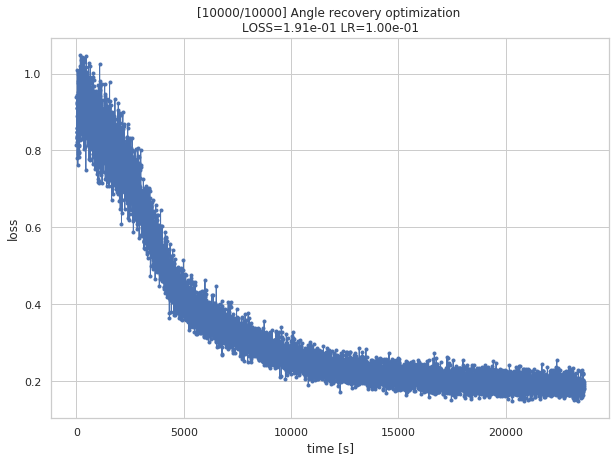

Shape of projections: (5000, 4)step 1000/10000 (2372s): loss = 7.81e-01
step 2000/10000 (4725s): loss = 4.85e-01
step 3000/10000 (7056s): loss = 3.91e-01
step 4000/10000 (9388s): loss = 2.92e-01
step 5000/10000 (11743s): loss = 2.55e-01
step 6000/10000 (14111s): loss = 2.39e-01
step 7000/10000 (16487s): loss = 1.94e-01
step 8000/10000 (18875s): loss = 2.13e-01
step 9000/10000 (21265s): loss = 1.99e-01
step 10000/10000 (23639s): loss = 1.79e-01



In [15]:
q_predicted, losses, q_all = train_angle_recovery(steps=10000, 
                                 batch_size=1024, 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True,
                                 file_name="data/5j0n/angle_recovery_perfect_le2")

In [22]:
from cryoem.angle_alignment import training_angle_alignment

In [23]:
data = np.load("data/5j0n/angle_recovery_perfect_le2.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

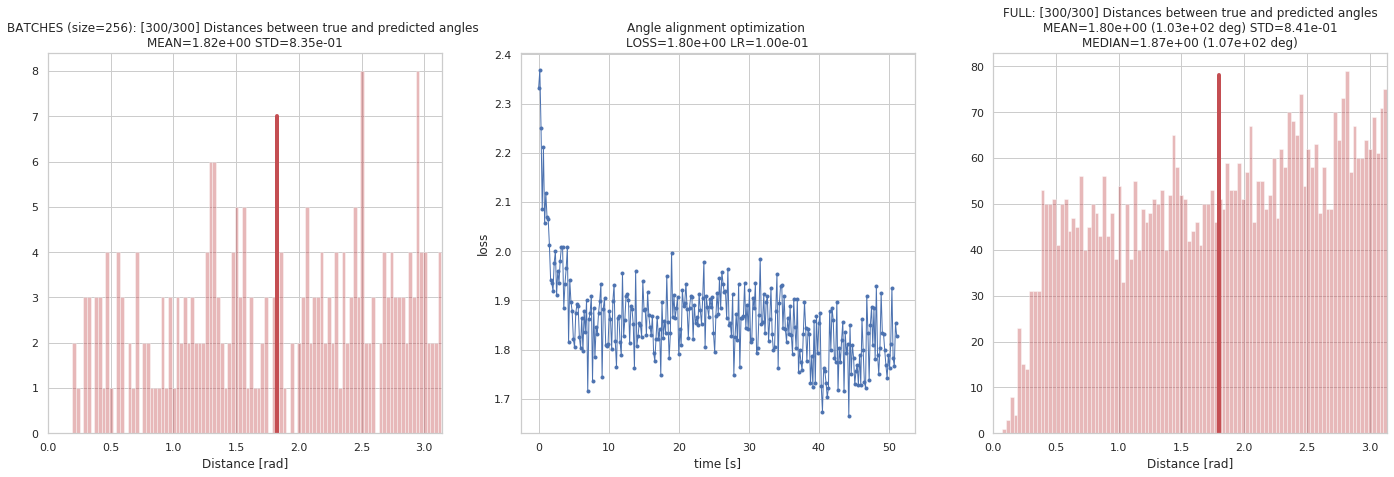

step 30/300 (6s): loss = 2.02e+00
step 60/300 (11s): loss = 1.84e+00
step 90/300 (16s): loss = 1.86e+00
step 120/300 (21s): loss = 1.85e+00
step 150/300 (26s): loss = 1.88e+00
step 180/300 (31s): loss = 1.87e+00
step 210/300 (36s): loss = 1.87e+00
step 240/300 (41s): loss = 1.81e+00
step 270/300 (47s): loss = 1.79e+00
step 300/300 (52s): loss = 1.82e+00

---


In [24]:
m, a_R, losses, collect_data = training_angle_alignment(m=[1., 1., 1., 1.], 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Adam, 
                                                        learning_rate=0.1, 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

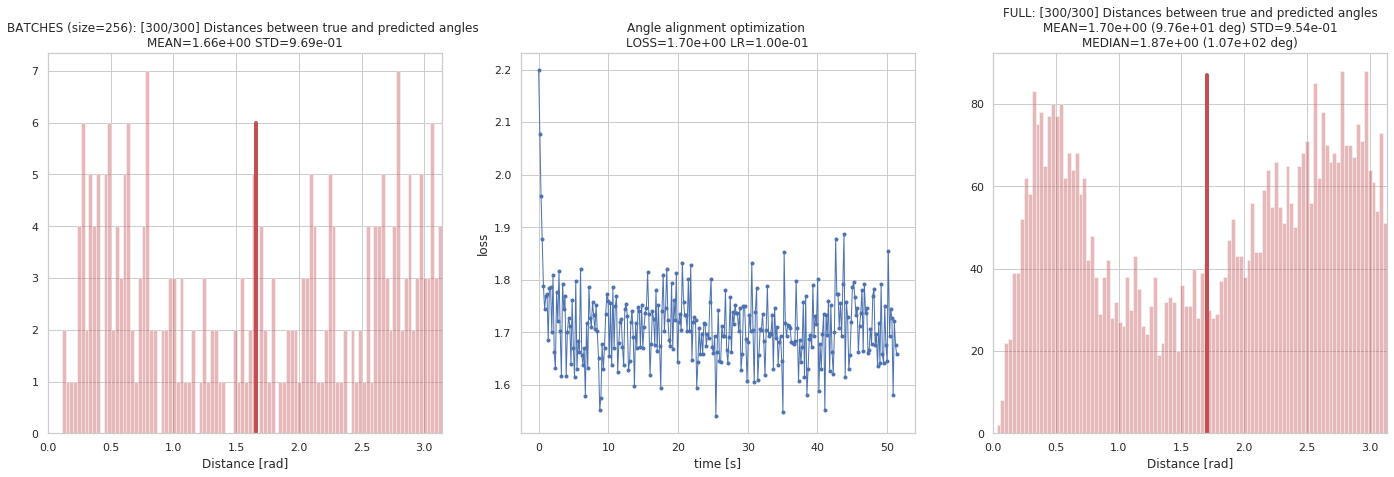

step 30/300 (6s): loss = 1.77e+00
step 60/300 (11s): loss = 1.69e+00
step 90/300 (16s): loss = 1.70e+00
step 120/300 (22s): loss = 1.72e+00
step 150/300 (27s): loss = 1.71e+00
step 180/300 (32s): loss = 1.71e+00
step 210/300 (37s): loss = 1.69e+00
step 240/300 (42s): loss = 1.69e+00
step 270/300 (47s): loss = 1.73e+00
step 300/300 (52s): loss = 1.71e+00

---


In [19]:
m, a_R, losses, collect_data = training_angle_alignment(m=[1., 1., 1., -1.], 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Adam, 
                                                        learning_rate=0.1, 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)